In [1]:
import sys
import os
import numpy as np
import torch
from scipy.integrate import simps
import matplotlib.pyplot as plt
os.chdir(os.getenv('POPRBM_TORCH'))
sys.path.append(os.getcwd() + '/src')
sys.path.append(os.getcwd() + '/data')
sys.path.append(os.getcwd() + '/models')
import h5py
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
dtype = torch.float

In [2]:
# use LaTeX fonts in the plots
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams.update({'font.size': 15})
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{bm}'

In [3]:
filename = "models/2023.12.6.12.29-ptt2_bernoulli.h5"
filename_data = "data/ptt2.dat"

In [4]:
class RBM:


    def __init__(
        self,
        num_visible,
        num_hidden,
        device,
        var_init=1e-4,
        dtype=torch.float,
    ):
        self.Nv = num_visible
        self.Nh = num_hidden
        self.device = device
        self.dtype = dtype
        self.W = (
            torch.randn(size=(self.Nh, self.Nv), device=self.device, dtype=self.dtype)
            * var_init
        )
        self.var_init = var_init
        self.vbias = torch.zeros(self.Nv, device=self.device, dtype=self.dtype)
        self.hbias = torch.zeros(self.Nh, device=self.device, dtype=self.dtype)


    def SampleHiddens01(self, V, β=1):
        
        mh = torch.sigmoid(β * (self.W.mm(V).t() + self.hbias).t())
        h = torch.bernoulli(mh)

        return h, mh

    def SampleVisibles01(self, H, β=1):
        

        mv = torch.sigmoid(β * (self.W.t().mm(H).t() + self.vbias).t())
        v = torch.bernoulli(mv)
        return v, mv

In [5]:
def TMCSample(
        rbm:RBM,
        v: torch.Tensor,
        w_hat: torch.Tensor,
        N: int,
        V: torch.Tensor,
        it_mcmc=0,
        it_mean=0,
        nb_point=torch.tensor([50,50]),
        nb_chain=10,
        direction=torch.tensor([0, 1]),
        β=1,
    ):
        """
        Tethered Monte-Carlo Algorithm on the visible units

        Parameters:
        -----------
        v : torch.tensor of shape (Nv, nb_point*nb_chain)
            starting point for the Markov chains

        w_hat : torch.tensor of shape (nb_point*nb_chain)
            Constraint parameter values

        N : int #TODO
        
        V : torch.tensor of shape (Nv, :)
            The projection vector from the dataset space to the constrained dimension
        
        it_mcmc : int, default=0
            The number of MCMC steps.
            If set to 0, use the class variable self.it_mcmc instead.
        
        it_mean : int, default=0
            The number of MCMC steps used for the temporal mean.
            If set to 0, use the class variable self.it_mean instead.
        
        β : float, default=1
            Effective temperature. Used for annealing.
        
        Returns:
        --------
        v_curr : torch.tensor of shape (Nv, nb_point*nb_chain)
            The last visible value of the MC chains.

        h_curr : torch.tensor of shape (Nh, nb_point*nb_chain)
            The last hidden value of the MC chains.

        vtab : torch.tensor of shape (Nv, nb_point*nb_chain)
            The temporal mean over the last it_mean visible values for each MC chain.
        """
        vtab = torch.zeros(v.shape, device=rbm.device)
        v_curr = v
        norm = 1 / (v_curr.shape[0] ** 0.5)
        w_curr = (torch.mm(v_curr.T, V) * norm)[
            :, direction
        ]  # Current tethered weight
        for t in range(it_mcmc):
            h_curr, _ = rbm.SampleHiddens01(v_curr)
            h_i = torch.mm(rbm.W.T, h_curr) + rbm.vbias.reshape(
                v.shape[0], 1
            )  #  Nv x Ns
            w_next = w_curr.clone()

            v_next = torch.clone(v_curr)
            for i in range(v_curr.shape[0]):
                v_next[i, :] = 1 - v_curr[i, :]  # Proposed change
                for j in range(w_next.shape[1]):
                    w_next[:, j] += (
                        (2 * v_next[i, :] - 1) * V[i, direction[j]] * norm
                    )  # New tethered weight

                # Compute -DeltaE
                ΔE = β * ((2 * v_next[i, :] - 1) * h_i[i, :]) - (N / 2) * (
                    torch.sum((w_hat.T - w_next) ** 2, dim=1)
                    - torch.sum((w_hat.T - w_curr) ** 2, dim=1)
                )

                tir = torch.rand(v_curr.shape[1], 1).to(rbm.device).squeeze()
                prob = torch.exp(ΔE).squeeze()
                # Update chains position with probability prob
                v_curr[i, :] = torch.where(tir < prob, v_next[i, :], v_curr[i, :])
                v_next[i, :] = torch.where(tir < prob, v_next[i, :], 1 - v_next[i, :])
                neg_index = torch.ones(w_curr.shape[0], dtype=bool)
                index = torch.where(tir < prob)[0]
                neg_index[index] = False
                w_curr[index, :] = w_next[index, :]
                w_next[neg_index, :] = w_curr[neg_index, :]
            # Temporal mean over the last it_mean iterations
            if t >= (it_mcmc - it_mean):
                vtab += v_curr
        vtab = vtab * (1 / it_mean)
        vtab = vtab.reshape(rbm.Nv, nb_point, nb_chain)
        v_curr = v_curr.reshape(rbm.Nv, nb_point, nb_chain)
        h_curr = h_curr.reshape(rbm.Nh, nb_point, nb_chain)
        return v_curr, h_curr, vtab

In [6]:

def compute_probability(rbm:RBM, vtab: torch.Tensor, direction, V0, w_hat_b, nb_point_dim, nDim, limits, N):
        
        newy = (
            torch.mm(torch.mean(vtab, dim=2).T, V0)[:, direction]
            / rbm.Nv ** 0.5
        )
        grad_pot = newy.T - w_hat_b
        square = torch.zeros(2, nb_point_dim[0], nb_point_dim[1])
        w_hat_tmp = np.zeros((2, nb_point_dim[0], nb_point_dim[1]))
        for i in range(0, grad_pot.shape[1], nb_point_dim[0]):
            w_hat_tmp[:, :, int(i / nb_point_dim[0])] = (
                w_hat_b[:, i : (i + nb_point_dim[0])].cpu().numpy()
            )
            square[:, :, int(i / nb_point_dim[0])] = grad_pot[
                :, i : (i + nb_point_dim[0])
            ]

        w_hat_dim = []
        for i in range(nDim):
            w_hat_dim.append(
                np.linspace(limits[0, i], limits[1, i], nb_point_dim[i])
            )

        res_x = np.zeros(nb_point_dim[0])
        for i in range(nb_point_dim[0]):
            res_x[i] = simps(
                square[0][: (i + 1), 0].cpu().numpy(), w_hat_tmp[0, : (i + 1), 0]
            )
        res_y = np.zeros((nb_point_dim[0], nb_point_dim[1]))
        for i in range(nb_point_dim[0]):
            for j in range(nb_point_dim[1]):
                res_y[i, j] = simps(
                    square[1][i, : (j + 1)].cpu().numpy(),
                    w_hat_tmp[1, i, : (j + 1)],
                )

        pot = np.expand_dims(res_x, 1).repeat(nb_point_dim[1].cpu(), 1) + res_y
        res = np.exp(N * (pot - np.max(pot)))

        const = np.zeros(res.shape[0])
        for i in range(res.shape[0]):
            const[i] = simps(res[:, i], w_hat_tmp[1, i, :])
        const = simps(const, w_hat_tmp[0, :, 0])
        p_m = torch.tensor(res / const, device=rbm.device, dtype=rbm.dtype)
        return square, p_m, w_hat_tmp, grad_pot, w_hat_dim

In [10]:
def ComputeProbabilityTMC2D(
    myRBM: RBM,
    data: torch.Tensor,
    nb_chain: int,
    it_mcmc: int,
    it_mean: int,
    N: int,
    nb_point_dim,
    border_length: float,
    V_g: torch.Tensor,
    device: torch.device,
    direction=torch.tensor([0, 1]),
    nDim=2,
    PCA=True,
    start=None,
):
    myRBM.device = device
    myRBM.gibbs_steps = it_mcmc
    
    if not PCA:
        _, _, V_g = torch.svd(myRBM.W)
        if torch.mean(V_g[:, 0]) < 0:
            V_g = -V_g
    proj_data = torch.mm(data.T, V_g).cpu() / myRBM.Nv ** 0.5
    limits = torch.zeros((2, nDim))
    for i in range(direction.shape[0]):
        limits[0, i] = proj_data[:, direction[i]].min() - border_length
        limits[1, i] = proj_data[:, direction[i]].max() + border_length
    nb_point = nb_point_dim.prod()
    x_grid = np.linspace(limits[0, 0], limits[1, 0], nb_point_dim[0])
    x_grid = np.array([x_grid for i in range(nb_point_dim[1])])
    x_grid = x_grid.reshape(nb_point)
    y_grid = []
    y_d = np.linspace(limits[0, 1], limits[1, 1], nb_point_dim[1])
    for i in range(nb_point_dim[1]):
        for j in range(nb_point_dim[0]):
            y_grid.append(y_d[i])
    grid = torch.tensor([x_grid, y_grid], device=device)
    w_hat = torch.zeros((nDim, nb_chain * nb_point), device=device)
    if start == None:
        start = torch.bernoulli(
            torch.rand(myRBM.Nv, nb_chain * nb_point, device=device)
        )
    w_hat = torch.zeros((2, nb_chain * nb_point), device=device)
    for i in range(nb_point):
        for j in range(nb_chain):
            w_hat[:, i * nb_chain + j] = grid[:, i]
    # TMC Sampling
    _, _, vtab = TMCSample(
        myRBM,
        start,
        w_hat,
        N,
        V_g,
        it_mcmc=it_mcmc,
        it_mean=it_mean,
        nb_chain = nb_chain,
        nb_point=nb_point
    )
    # Probability reconstruction
    square, p_m, w_hat_tmp, _, _ = compute_probability(myRBM, vtab, direction, V_g, grid, nb_point_dim, nDim, limits, N)

    return square, p_m, w_hat_tmp

In [7]:
f = h5py.File(filename, 'r')
pc = f["parallel_chains"][()]

epochs = []
for key in f.keys():
    if "epoch" in key:
        ep = int(key.replace("epoch_", ""))
        epochs.append(ep)
epochs = np.sort(epochs)
print("epochs:", epochs)

epochs: [   1    2    3    4    5    6    7    9   10   12   13   15   18   20
   23   27   31   36   41   47   54   63   72   83   95  109  125  144
  165  190  218  251  288  331  380  436  501  575  660  758  870 1000]


In [8]:
epoch = 1000
n_data = 5000

epoch = f"epoch_{epoch}"
X = torch.tensor(np.loadtxt(filename_data)[:n_data], device=device).type(torch.float32).mT
f = h5py.File(filename, 'r')
W = torch.tensor(f[epoch]["weight_matrix"][()], device=device)
vbias = torch.tensor(f[epoch]["vbias"][()], device=device)
hbias = torch.tensor(f[epoch]["hbias"][()], device=device)

Nv, Nh = W.shape

rbm = RBM(device=device, num_hidden=Nh, num_visible=Nv)
rbm.W = W.mT
rbm.vbias = vbias
rbm.hbias = hbias

Vpca, _, U = torch.svd((X - torch.mean(X,1).reshape(X.shape[0], 1)) / np.sqrt(X.shape[1]))

if torch.mean(Vpca[:,0]) <= 0:
    Vpca = -Vpca
    
V = Vpca

X_proj = ((X) / np.sqrt(X.shape[0])).mT @ Vpca
X_proj = X_proj.cpu().numpy()

In [11]:
square, p_m, w_hat_b = ComputeProbabilityTMC2D(rbm, X,
    nb_chain = 100,
    it_mcmc = 100,
    it_mean = 25,
    N = 20000,
    nb_point_dim = torch.tensor([50,50]) ,
    border_length = 0.1,
    V_g = V.to(device),
    device = device,
    direction = torch.tensor([0,1]),
    nDim = 2,
    PCA = True,
)

/tmp/ipykernel_967743/4003700507.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  grid = torch.tensor([x_grid, y_grid], device=device)


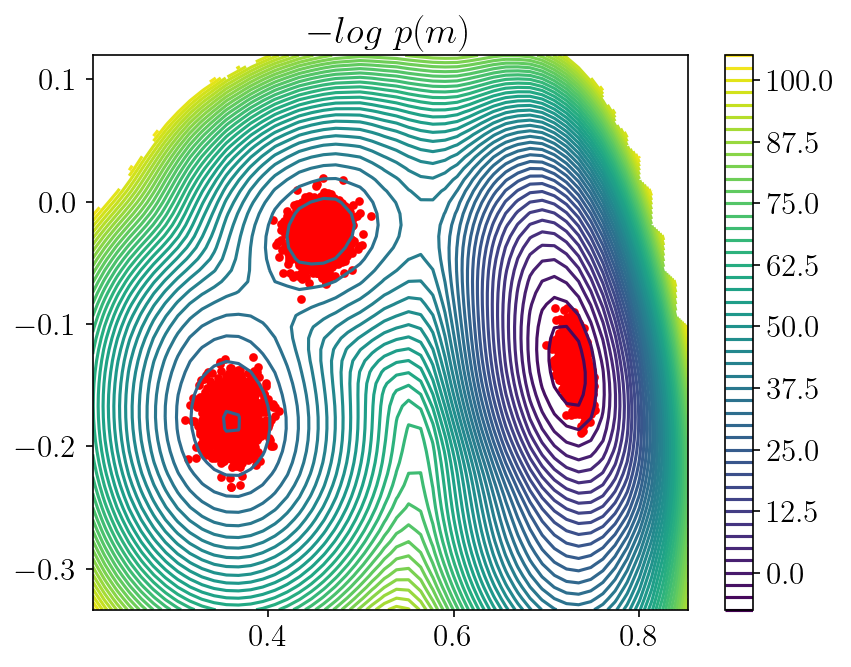

In [12]:
fig, ax = plt.subplots(dpi=150)
# ax.scatter(proj_data[:, direction[0]], proj_data[:, direction[1]], c='b', s=1
#            , label='Data') # Plot the data
proba_cont = ax.contour(w_hat_b[0], w_hat_b[1], -torch.log(p_m).cpu().numpy(), 50) # Plot the contour of the probability
ax.scatter(X_proj[:, 0], X_proj[:, 1], color='red', s=10)
ax.set_title(r'$-log~p(m)$')
#ax.legend()
fig.colorbar(proba_cont, ax=ax);

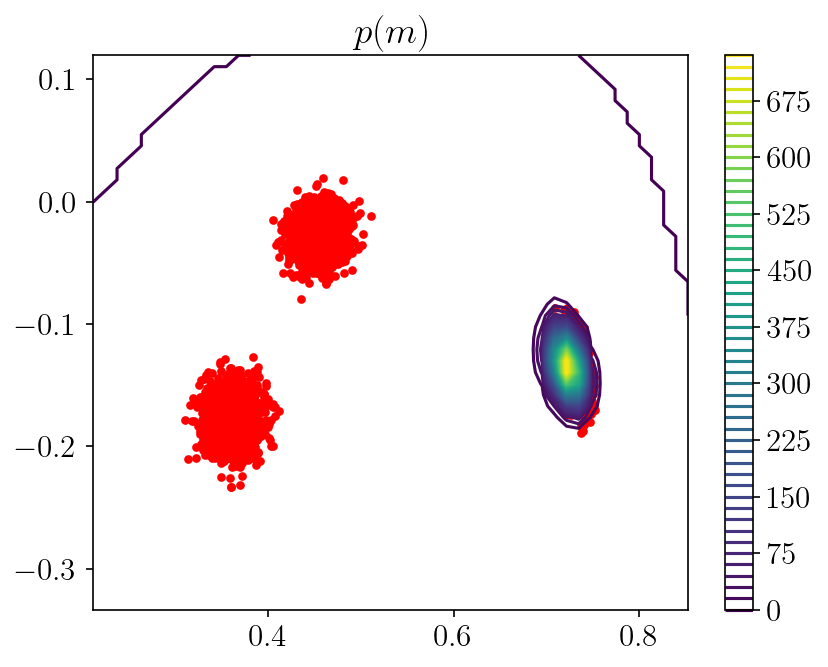

In [13]:
fig, ax = plt.subplots(dpi=150)
# ax.scatter(proj_data[:, direction[0]], proj_data[:, direction[1]], c='b', s=1
#            , label='Data') # Plot the data
proba_cont = ax.contour(w_hat_b[0], w_hat_b[1], p_m.cpu().numpy(), 50) # Plot the contour of the probability
ax.scatter(X_proj[:, 0], X_proj[:, 1], color='red', s=10)
ax.set_title(r'$p(m)$')
#ax.legend()
fig.colorbar(proba_cont, ax=ax);

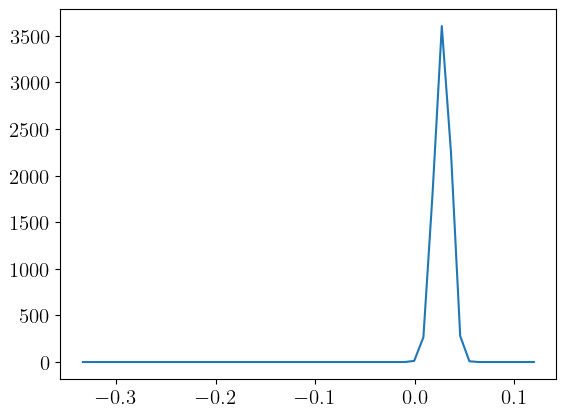

In [14]:
fig = plt.figure(dpi=100)
dir=0
plt.plot(w_hat_b[1][1], p_m.sum(abs(dir-1)).cpu().numpy());